This document demonstrate how to use the library to define a "density dependent population process" and to compute its mean-field approximation and refined mean-field approximation 

In [1]:
# To load the library
import src.rmf_tool as rmf

import importlib
importlib.reload(rmf)

# To plot the results
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Example : The two-choice model

This example illustrate **two ways** of constructing models:
* How to define transitions with a **for loop**  (using the 'eval' function)
* How to use a parameter in the transitions 

The transitions for this model are: 
* $x \mapsto x + \frac1N e_k$ at rate $\rho (x_{k-1}x_{k-1} - x_k x_k)$
* $x \mapsto x - \frac1N e_k$ at rate $\rho (x_k - x_{k+1})$

with the convention : $x_{-1} = 1$ and $x_{K} = 0$ for some $K$. 

In [2]:
# This code creates an object that represents a "density dependent population process"
ddpp = rmf.DDPP()
K = 20

# The vector 'e(i)' is a vector where the $i$th coordinate is equal to $1$ (the other being equal to $0$)
def e(i):
    l = np.zeros(K)
    l[i] = 1
    return(l)

# We then add the transitions : 
for i in range(K):
    if i>=1:
        ddpp.add_transition(e(i),eval('lambda x: rho*(x[{}]*x[{}] - x[{}]*x[{}] )'.format(i-1,i-1,i,i) ))
    if i<K-1:
        ddpp.add_transition(-e(i),eval('lambda x: (x[{}] - x[{}])'.format(i,i+1) ))
ddpp.add_transition(e(0), lambda x : rho*(1-x[0]*x[0]))
ddpp.add_transition(-e(K-1), lambda x : x[K-1])



## Simulation and comparison with ODE
We can easily simulate one sample trajectory

### Simulation for various values of $N$

CPU times: user 765 ms, sys: 8.17 ms, total: 773 ms
Wall time: 781 ms
CPU times: user 2.91 s, sys: 30 ms, total: 2.94 s
Wall time: 2.96 s


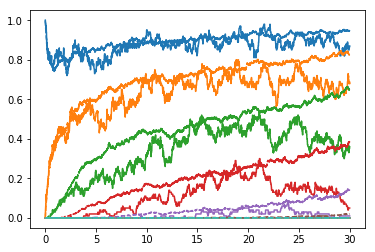

In [3]:
rho = 0.95
ddpp.set_initial_state(e(0)) # We first need to define an initial stater
%time c = ddpp.theoretical_V()

T,X = ddpp.simulate(100,time=30) # We first plot a trajectory for $N=100$
plt.plot(T,X)
%time T,X = ddpp.simulate(1000,time=30) # Then for $N=1000$
plt.plot(T,X,'--')

### Comparison with the ODE approximation 
We can easily compare simulations with the ODE approximation

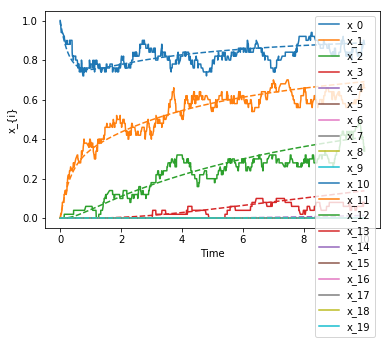

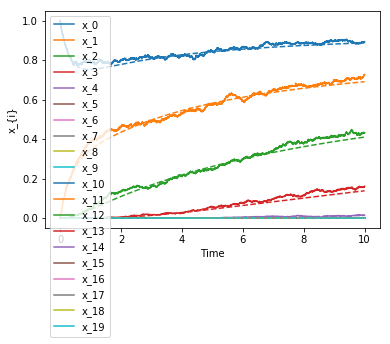

In [4]:
plt.figure()
ddpp.plot_ODE_vs_simulation(N=50)
plt.figure()
ddpp.plot_ODE_vs_simulation(N=1000)

## Refined mean-field approximation
(reference to be added)

This class also contains some functions to compute the fixed point of the mean-field approximation, to compute the "refined mean-field approximation" and to compare it with simulations. 

If $x$ is the fixed point of the ODE, and $C$ the constant calculated by the function "theoretical_C()", then we have 

$$E[X^N] = x + \frac1N C + o(\frac1N) $$

To compute these constants : 

In [5]:
x = ddpp.fixed_point()
c = ddpp.theoretical_V()
print(x,c)

[ 9.50000000e-001  8.57375000e-001  6.98337296e-001  4.63291230e-001
  2.03906826e-001  3.94990939e-002  1.48216950e-003  2.08698510e-006
  4.13773145e-012  1.62647805e-023  1.93413448e-046  5.32194950e-064
 -1.60947770e-080 -3.21516537e-094 -1.74427669e-108 -1.45629903e-123
  8.38220925e-137  1.26425726e-150  1.18599966e-164  7.84612063e-179] [ 4.30645103e-016  7.43796815e-002  4.57609741e-001  1.62142167e+000
  3.34929643e+000  2.88723561e+000  4.84199820e-001  4.21066458e-003
  2.01887601e-006  3.93088442e-012  1.54515414e-023  2.11246454e-046
  2.52792601e-064 -7.64501909e-081 -1.52720355e-094 -8.28531428e-109
 -6.91742039e-124  3.98154940e-137  6.00522198e-151  5.63349840e-165]


### Comparison of theoretical C and simulation 

We observe that, for this model, the mean-field approximation is already very close to the simulation. 

**Warning** : for $time=100000/N$, the simulation takes about $10$ sec per value of $N$ but is not that accurate

In [6]:
from misc.jsqD_simulate.average_valueJSQ import loadSteadyStateDistributionQueueLength

print(sum(x),'(mean-field)')

myN = [10,20,30,50,100]
Xs = {}
Vs = {}
Xrmf = {}
for N in myN:
    # For steady-state simulation, 2 options : 
    #  Option 1 : we could use the tool (to do so uncomment the line below)
    #%time Xs[N],Vs[N] = ddpp.steady_state_simulation(N=N,time=100000/N) 
    #  Option 2 : we use simulations from an external tool
    Xs[N],Vs[N] = loadSteadyStateDistributionQueueLength(N=N,d=2,rho=rho,returnConfInterval=True)
    Xrmf[N] = x+c/N
    print(N,'done')

3.213893702158946 (mean-field)
10 done
20 done
30 done
50 done
100 done


#### Refined mean-field for the average queue length 
The average queue length is accurately predicted by the refined mean-field 

In [8]:
# Average queue length : 
for N in myN : 
    print(sum(Xs[N]),'+/-',sum(Vs[N]),'(Simulation, N={})'.format(N))
    print(sum(Xrmf[N]),'(refined mean-field, N={})'.format(N))

4.299337592945664 +/- 0.003121522842239723 (Simulation, N=10)
4.101729265260641 (refined mean-field, N=10)
3.712400436129647 +/- 0.0019717101682678578 (Simulation, N=20)
3.6578114837097937 (refined mean-field, N=20)
3.533207497451201 +/- 0.0016622364756101527 (Simulation, N=30)
3.5098388898595116 (refined mean-field, N=30)
3.398233472831268 +/- 0.001350448813969049 (Simulation, N=50)
3.3914608147792857 (refined mean-field, N=50)
3.3066212589208 +/- 0.0011551609415924524 (Simulation, N=100)
3.302677258469117 (refined mean-field, N=100)


#### Queue length distribution 

Interestingly, the distribution is not really predicted well for $N=10$ (the refined mean-field over-correct the values around 5).  it seems better for $N\ge30$. 


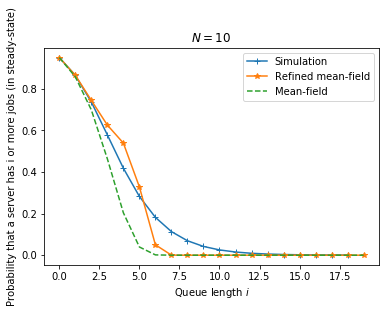

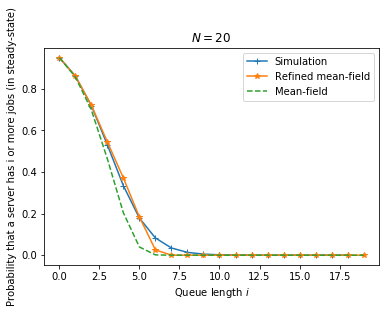

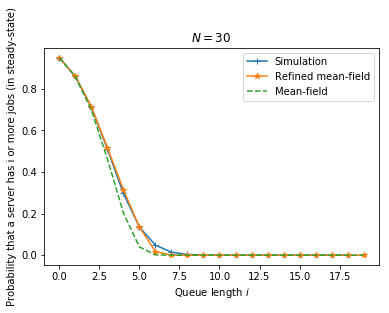

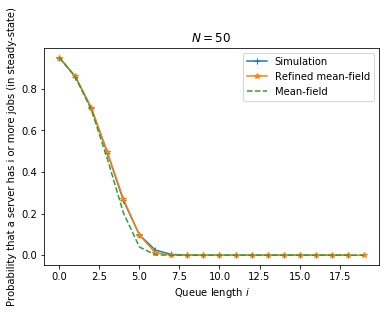

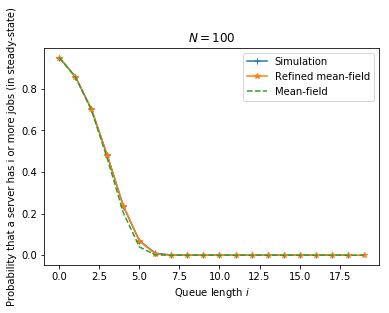

In [9]:
for N in myN:
    plt.figure()
    #plt.errorbar(range(K-1),-np.diff(Xs[N]),np.diff(-Vs[N]))
    #plt.plot(-np.diff(Xs[N]),'+-')
    #plt.plot(-np.diff(Xrmf[N]),'*-')
    #plt.plot(-np.diff(x),'--')
    plt.plot((Xs[N]),'+-')
    plt.plot((Xrmf[N]),'*-')
    plt.plot((x),'--')
    plt.legend(('Simulation','Refined mean-field','Mean-field'))
    plt.xlabel('Queue length $i$')
    plt.ylabel('Probability that a server has i or more jobs (in steady-state)')
    plt.title('$N={}$'.format(N))